In [1]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create mesh and define function space
mesh = UnitSquareMesh(2, 2)
V = FunctionSpace(mesh, 'CG', 1)
Vc = FunctionSpace(mesh,'DG',0)

# Define Dirichlet boundary (x = 0 or x = 1)
def boundary_left(x):
    return x[0] < DOLFIN_EPS

def boundary_right(x):
    return x[0] > 1.0 - DOLFIN_EPS

# Define boundary condition
u0 = Constant(0.0)
u1 = Constant(10.0)
#bc = DirichletBC(V, u0, boundary)
mybc_expr = Expression('10*x[1]+1',degree=2)

#Define Neumann boundary condition
u_x = '0.0-2.0*x[1]'
u_y = '1.0-2.0*x[0]'
flowField = Expression((u_x, u_y), degree=2)
bcFlux = inner(FacetNormal(mesh), flowField)


bc = [DirichletBC(V, u1, boundary_left), DirichletBC(V, mybc_expr, boundary_right)]

theta = Function(Vc)
theta.vector()[:] = 1 + np.abs(np.random.normal(0,0.05,Vc.dim()))

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)",degree=2)
a = theta*inner(grad(u), grad(v))*dx
L = f*v*dx + bcFlux * v * ds

# Compute solution
u = Function(V)
solve(a == L, u, bc)

u_solution_vec = u.vector().get_local()

In [3]:
# For repeated finite difference evaluation
def ForwardSolver(x):
    
    uu = TrialFunction(V)
    vv = TestFunction(V)
    thetal = Function(Vc)
    thetal.vector()[:] = x
    aa = thetal*inner(grad(uu), grad(vv))*dx
    LL = f*vv*dx
    uu = Function(V)
    solve(aa==LL,uu,bc)
    return uu.vector().get_local()

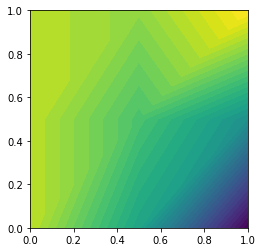

In [4]:
# Plot of solution
plot(u)

### Functional : to be replaced with Gaussian likelihood
Here depends on the solution vector u.vector().array()

In [5]:
# Make up bogus functional
H = np.abs(np.random.normal(0,1,(V.dim(), V.dim())))
H = H + H.T + np.eye(V.dim())
#H = np.eye(V.dim())

# A functional of the solution which by construction has H as the Hessian
def Functional(x):
    return -0.5*x.dot(H.dot(x))

# Finite Differences

In [6]:
# Get Finite Difference Vector

h = 1e-10

x0 = theta.vector().array()
grad_fd = np.zeros(Vc.dim())

for i in range(Vc.dim()):
    xp = x0.copy()
    xm = x0.copy()
    
    xp[i] = xp[i] + h
    xm[i] = xm[i] - h
        
    upv = ForwardSolver(xp)
    Lp = Functional(upv)
    
    upm = ForwardSolver(xm)
    Lm = Functional(upm)
    
    grad_fd[i] = (Lp - Lm)/(2*h)
    

/home/constantin/.conda/envs/pyadjoint/lib/python3.5/site-packages/dolfin/cpp/la.py:1128: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


In [7]:
# reset theta for adjoint
theta.vector()[:] = x0
solve(a==L,u,bc)

# Adjoint Method

In [8]:
# derivative of residual wrt u
K = assemble(a)

# we need to apply boundary condition to K
for mybc in bc:
    mybc.apply(K)
    
    
K = K.array()

# derivative of functional wrt u
b = -H.dot(u.vector().get_local())

helperfunction = Function(V)
helperfunction.vector()[:] = b
for mybc in bc:
    mybc.homogenize()
    mybc.apply(helperfunction.vector())
    
b = helperfunction.vector().get_local()

# get lambda
lmbda = np.linalg.solve(K, b)

In [9]:
#helperfunction = Function(V)
#helperfunction.vector()[:] = b


In [10]:
# derivative of r wrt theta
# the trick is that here we are not using u as trial functions, but instead as function
r = theta*inner(grad(u), grad(v))*dx    # the part of the residual that depends on theta

dr_dtheta = assemble(derivative(r,theta)).array()

grad_adjoint = -lmbda.dot(dr_dtheta)


In [11]:
print("Relative Error (L2): {}".format(np.linalg.norm(grad_fd - grad_adjoint)/np.linalg.norm(grad_fd)))

Relative Error (L2): 2.6585060027829035e-05


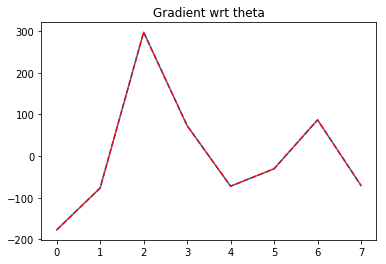

In [12]:
plt.plot(grad_fd[::1])
plt.plot(grad_adjoint[::1],'r--')
plt.title('Gradient wrt theta');

In [13]:
np.linalg.norm(grad_fd - grad_adjoint)/np.linalg.norm(grad_fd)

2.6585060027829035e-05